# DHO-simulated Light Curves Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl

from celerite import GP
import eztao
# from eztao.carma import DRW_term,DHO_term, CARMA_term
from eztao.carma import *
from eztao.ts import gpSimRand,gpSimFull
from eztao.ts import drw_fit
from eztao.ts import gpSimFull, gpSimByTime
from eztao.ts.carma_fit import sample_carma
from eztao.carma import gp_psd
from eztao.ts import drw_fit
from eztao.ts import dho_fit


In [2]:
from dho.inputs_transform import *
import random
from sympy import *

ModuleNotFoundError: No module named 'sympy'

### 1. DHO Params Set Design

In [109]:
'''
For DHO, there are two types that might fit astronomical time-series: underdamping, overdamping.
We will design 200 DHO light curves for each type
'''


    

# For underdamping type, ~2.0 <  ζ  < 5.0   and 60 < t_decay < 200.
# For overdamping  type, 0 < t_rise < 5.0, and 60 < t_decay < 200



# import sample z and SF from s82, in this way we have 1000 samples
sample_z = pd.read_csv('s82_z_1000.csv')
sample_sf = pd.read_csv('s82_SFG_1000.csv')

redshift = sample_z['redshift']
variance = sample_sf['SFG']**2/2


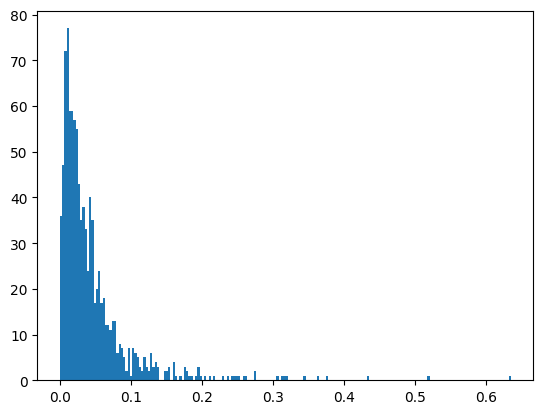

In [110]:
plt.hist(variance, bins = 200)
plt.show()

### 1.1 Underdamping

In [568]:
# DHO sigma^2 = (beta0^2+beta1^2*alpha2)/(2*alpha1*alpha2)
# We need to set beta0, beta1 unchanged, in this way, we can control alpha*, and then timescales.
beta_0, beta_1 = 0.0022, 0.00025

# as alpha* are not straightforward for studying, we need to use timescales as input parameters 
# for underdamping and overdamping, we set 60 < t_decay < 200, 
# which means that 1/100< alpha_1< 1/30. Everytime we randomly select one variance from sample set, 
# we randomly select one alpha_1 from that interval, and then conclude alpha_0



# underdamping

tau_list = [random.uniform(60, 200) for i in np.arange(1000)]

alpha1_l = []
alpha2_l = []
QPO_l = []
tau_l = []
sf_l = []
z_l = []

compare = []

n = 0
while n<len(tau_list):
    alpha_1 = 2/tau_list[n]
    var = np.random.choice(variance)
    alpha_2 = beta_0**2/(2*alpha_1*var-beta_1**2)
    if alpha_1**2-4*alpha_2<0 and alpha_2>0:
        alpha1_l.append(alpha_1)
        alpha2_l.append(alpha_2)
        QPO_l.append(2*np.pi/np.sqrt(alpha_2))
        tau_l.append(tau_list[n])
        z_l.append(np.random.choice(redshift))
        sf_l.append(np.sqrt(var*2))
        compare.append(alpha_1**2-4*alpha_2)
        
    n +=1

beta0_l = [beta_0]*len(alpha1_l)
beta1_l = [beta_1]*len(alpha1_l)
df_under = pd.DataFrame(list(zip(alpha1_l, alpha2_l, beta0_l, beta1_l, QPO_l,tau_l,z_l,sf_l)), 
                       columns = ['alpha_1','alpha_2', 'beta_0','beta_1','T_QPO', 'T_decay','redshift','SFG'])


In [571]:
df_under.to_csv('DHO_under_params.csv')

In [572]:
df_under

,alpha_1,alpha_2,beta_0,beta_1,T_QPO,T_decay,redshift,SFG
0,0.018050,0.003535,0.0022,0.00025,105.680418,110.800765,3.2013,0.275425
1,0.027307,0.001007,0.0022,0.00025,197.992063,73.241033,1.7329,0.419523
2,0.019648,0.014994,0.0022,0.00025,51.312754,101.793656,2.5506,0.128190
3,0.010566,0.008395,0.0022,0.00025,68.576238,189.289790,2.7457,0.233608
4,0.010596,0.004566,0.0022,0.00025,92.983794,188.758871,1.2761,0.316302
...,...,...,...,...,...,...,...,...
995,0.024642,0.001657,0.0022,0.00025,154.353307,81.163435,1.5009,0.344293
996,0.013253,0.006111,0.0022,0.00025,80.377825,150.909543,1.1021,0.244478
997,0.010473,0.007337,0.0022,0.00025,73.354755,190.971252,1.0524,0.250992
998,0.012321,0.002976,0.0022,0.00025,115.185890,162.323817,1.0773,0.363351


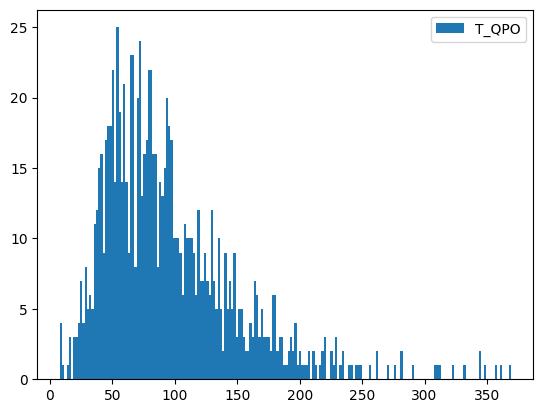

369.07785733062076 7.989165199268459 82.33029313474489


In [567]:
plt.hist(QPO_l, bins= 200, label = 'T_QPO')
# # plt.hist(tau_l, bins= 200, label = 'T_decay')
plt.legend()
plt.show()
print(max(QPO_l), min(QPO_l), np.median(QPO_l))


### 1.2 Overdamping

In [125]:
from sympy import *


# overdamping


beta_0, beta_1 = 0.003672,0.0257


tau_list = [random.uniform(60, 200) for i in np.arange(20000)]
# rise_list = [random.uniform(0, 60) for i in np.arange(20000)]
var_list = [float(variance.sample(1)) for i in np.arange(20000)]


alpha1_l = []
alpha2_l = []
rise_l = []
tau_l = []
sf_l = []
z_l = []


n = 0
m = 0
while n<len(tau_list) and m<1000:
    alpha_1= Symbol('alpha_1')
    alpha_2= Symbol('alpha_2')
    var = var_list[n]
    tau = tau_list[n]
    solved_value = solve([tau*alpha_1 - tau**2*alpha_2 -1, 
                           (beta_0**2+beta_1**2*alpha_2)/(2*alpha_1*alpha_2)-var],
                         [alpha_1, alpha_2])
    alpha_1 = float(solved_value[1][0])
    alpha_2 = float(solved_value[1][1])

#     print(solved_value)
    
    if  alpha_1**2-16*alpha_2>=0 and alpha_1**2-100*alpha_2 <=0 and alpha_2<1 and alpha_1<1 and alpha_1>0 and alpha_2>0:
        
        r1 = (-1*alpha_1+np.sqrt(alpha_1**2-4*alpha_2))/2
        r2 = (-1*alpha_1-np.sqrt(alpha_1**2-4*alpha_2))/2
        rise = 1/(r2-r1)*np.log(r1/r2)
        alpha1_l.append(alpha_1)
        alpha2_l.append(alpha_2)
        rise_l.append(rise)
        tau_l.append(tau_list[n])
        z_l.append(np.random.choice(redshift))
        sf_l.append(np.sqrt(var*2))
        m += 1
        
    n +=1
    
    
# print(alpha1_l)

beta0_l = [beta_0]*len(alpha1_l)
beta1_l = [beta_1]*len(alpha1_l)
df_over = pd.DataFrame(list(zip(alpha1_l, alpha2_l, beta0_l, beta1_l, rise_l,tau_l,z_l,sf_l)), 
                       columns = ['alpha_1','alpha_2', 'beta_0','beta_1','T_rise', 'T_decay','redshift','SFG'])




In [126]:
df_over.to_csv('DHO_over_params.csv')
df_over

,alpha_1,alpha_2,beta_0,beta_1,T_rise,T_decay,redshift,SFG
0,0.454327,0.003586,0.003672,0.0257,9.166481,124.470545,0.8060,0.098646
1,0.200009,0.001004,0.003672,0.0257,19.148572,194.030412,0.9659,0.265389
2,0.268110,0.001587,0.003672,0.0257,14.715866,165.072079,2.2427,0.184779
3,0.343198,0.001810,0.003672,0.0257,12.464558,186.692579,0.9659,0.153737
4,0.288367,0.002937,0.003672,0.0257,12.232252,94.596906,0.6358,0.134956
...,...,...,...,...,...,...,...,...
995,0.232007,0.002056,0.003672,0.0257,14.909460,108.365030,1.7970,0.176398
996,0.220654,0.001781,0.003672,0.0257,15.847178,119.194516,1.9182,0.193152
997,0.128454,0.000857,0.003672,0.0257,24.878084,141.606303,1.1124,0.357196
998,0.117779,0.000764,0.003672,0.0257,26.712367,145.054813,2.2749,0.394167


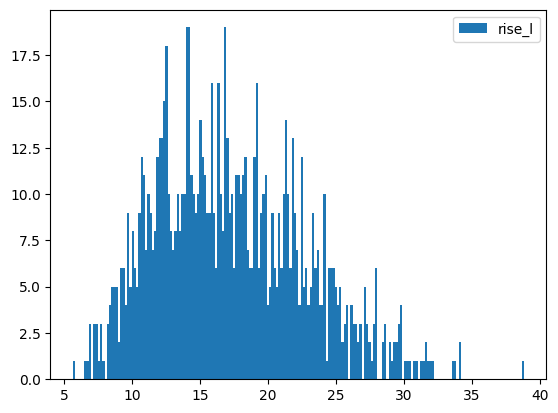

In [127]:
plt.hist(df_over['T_rise'], bins= 200, label = 'rise_l')
# plt.hist(tau_l, bins= 200, label = 'T_decay')
plt.legend()
plt.show()

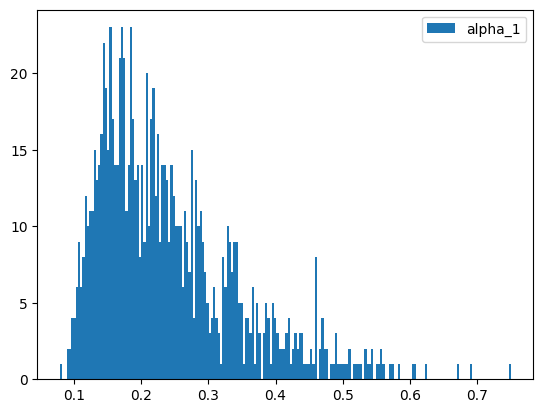

In [128]:
df = pd.read_csv('DHO_over_params.csv',index_col=0)

plt.hist(df['alpha_1'], bins= 200, label = 'alpha_1')
# plt.hist(df['alpha_2'], bins= 200, label = 'alpha_2')
plt.legend()
plt.show()

In [129]:
print(min(df['T_rise']),  max(df['T_rise']))

5.640673446251108 38.83533012357635


### 2. DHO light curve

In [6]:
def plot_dho(t_dho, y_dho, yerr_dho):

    # plot the simulated process
    plt.figure(figsize = (16,3))
    plt.errorbar(t_dho/365, y_dho, yerr_dho, fmt='.')
    plt.xlabel('Years', fontsize = 24)
    plt.ylabel('Mag', fontsize = 24)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

In [7]:
def add_lsst_noise(mag, gamma = 0.039, alpha_sys = 0.005, m5 = 24.7):
    x = 10**(0.4*(mag-m5))
    alpha_rand_2 = (0.04-gamma)*x + gamma*(x**2)
    alpha_lsst_2 = alpha_sys**2+alpha_rand_2
    noise = np.random.normal(0,np.sqrt(alpha_lsst_2))
    return mag, noise



T_rise:  21.123641484453067 
T_decay:  182.4598791041379
variance: 0.044454642393779976


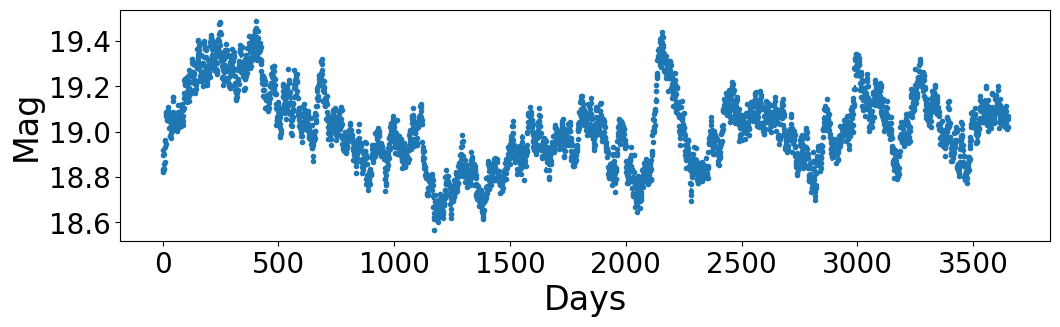

In [135]:
# df = pd.read_csv('DHO_under_params.csv',index_col=0)
df = pd.read_csv('DHO_over_params.csv',index_col=0)



rand = random.randrange(0,len(df))
alpha_1 = df['alpha_1'][rand]
alpha_2 = df['alpha_2'][rand]
beta_0 = df['beta_0'][rand]
beta_1 = df['beta_1'][rand]
sigma2 = (df['SFG'][rand])**2/2
print('T_rise: ', df['T_rise'][rand],'\nT_decay: ',df['T_decay'][rand])

# print('T_QPO: ', df['T_QPO'][rand],'\nT_decay: ',df['T_decay'][rand])


ar = [alpha_1, alpha_2]
ma = [beta_0, beta_1]

# print(ar,ma)

# print(sigma2)



# test

# ar = [0.0315763935871705, 0.000215763935871705] 
# ma = [0.004672, 0.0257]
print('variance:',(beta_0**2+beta_1**2*alpha_2)/(2*alpha_1*alpha_2))


# define a DHO/CARMA(2,1) kernel
dho_kernel = DHO_term(np.log(ar[0]), np.log(ar[1]), np.log(ma[0]), np.log(ma[1]))
nLC = 1
SNR = 10
duration = 365*10
npts = 365*10
t_dho, y_dho, yerr_dho = gpSimFull(dho_kernel, SNR, duration, npts, nLC=nLC, log_flux=True)


y_dho += 19
yerr_dho = np.zeros(len(y_dho))
y_dho, yerr_dho = add_lsst_noise(y_dho)

# plot the light curve

plt.figure(figsize = (12,3))
plt.errorbar(t_dho, y_dho, yerr_dho, fmt='.')
plt.xlabel('Days', fontsize = 24)
plt.ylabel('Mag', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# plt.xlim([0,1000])
# plt.yticks(np.linspace(21.5,22,5))
plt.show()


In [136]:
np.var(y_dho)

0.027171356175775548

In [328]:
v = (beta_0**2+beta_1**2*alpha_2)/(2*alpha_1*alpha_2)
np.sqrt(v)

# overdamped
# 1/(2*np.sqrt(alpha_1**2-4*alpha_2))*(beta_1**2+beta_0**2/alpha_2)

0.18257553658779152

In [115]:
# test sympy
from sympy import DiracDelta
f = symbols('f', cls=Function)
x = symbols('x')
alpha_1,alpha_2, beta_0, beta_1 = symbols('alpha_1,alpha_2, beta_0, beta_1')
# alpha_1 = 0.04
# alpha_2 = 0.005
# beta_0 = 0.0002
# beta_1 = 0.00004
eq = Eq(f(x).diff(x, x) + alpha_1*f(x).diff(x) + alpha_2*f(x), DiracDelta(x))
func = dsolve(eq,f(x))
print(func)

Eq(f(x), C1*exp(x*(-alpha_1 - sqrt(alpha_1**2 - 4*alpha_2))/2) + C2*exp(x*(-alpha_1 + sqrt(alpha_1**2 - 4*alpha_2))/2) - exp(x*(-alpha_1 - sqrt(alpha_1**2 - 4*alpha_2))/2)*Heaviside(x)/sqrt(alpha_1**2 - 4*alpha_2) + exp(x*(-alpha_1 + sqrt(alpha_1**2 - 4*alpha_2))/2)*Heaviside(x)/sqrt(alpha_1**2 - 4*alpha_2))


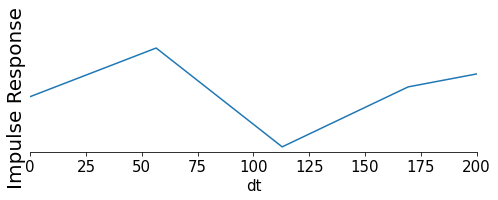

In [202]:
plot_ImpulseResponse(ar)

In [99]:
np.std(y_dho)

7.3883153234927965

In [376]:
def calculate_SF(mjd, flux):
    # convert mjd to integer
    mjd = mjd.astype(int).tolist()
    flux = flux.astype(float).tolist()
    
    #initialize the delta time
    delta = 1
    obs_SF_list = []
    delta_list = []
    obs_len = max(mjd) - min(mjd)
    while delta < obs_len:
        n = min(mjd)
        count = 0
        mag_vals = 0.0
        while n <= max(mjd)-delta:
            if n in mjd and n+delta in mjd: 
                
                mag_vals += (flux[mjd.index(n+delta)] - flux[mjd.index(n)])**2   
                count +=1
            n = n + delta
        if count>0:
            obs_SF_list.append(np.sqrt(mag_vals/count))
            delta_list.append(delta)  
        delta +=1
    return obs_SF_list, delta_list

def plot_obs_SF(obs_SF_list, delta_list, band, SF_inft):
   
    plt.figure(figsize = (10,6))
    plt.scatter(np.log10(np.array(delta_list)), obs_SF_list, s = 3, color = 'black', label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(np.log10(np.array(delta_list))), max(np.log10(np.array(delta_list))), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel(r'$log_{10}(\Delta t)$', fontsize=20)
    plt.yscale('log')
    plt.legend(fontsize = 20)
    plt.ylabel('Structure Function', fontsize=20)
    plt.title('Structure Function (Observed) ' + band +' band',fontsize=20 )
    
   

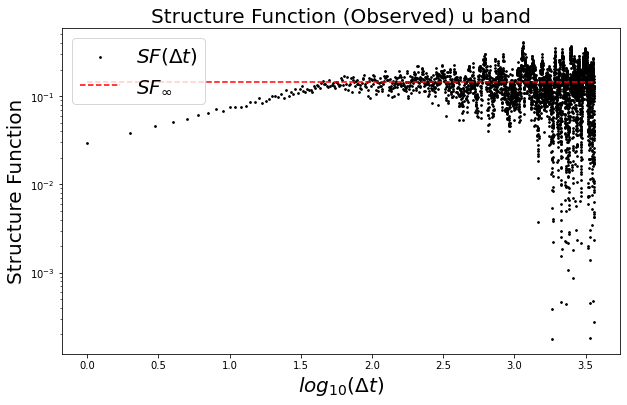

In [377]:

y_dho += 24.0

obs_SF_list, delta_list = calculate_SF(t_dho, y_dho)
plot_obs_SF(obs_SF_list, delta_list, 'u', np.std(y_dho)*np.sqrt(2))

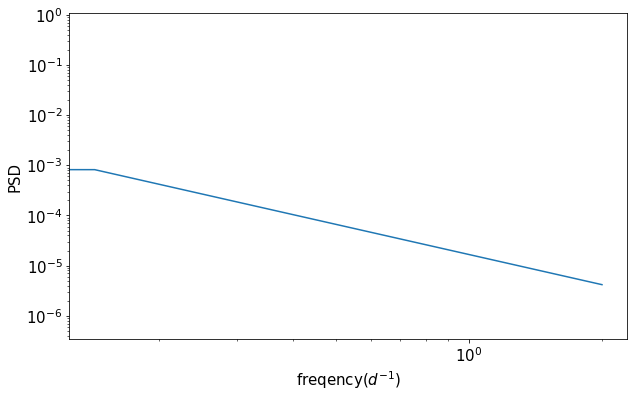

In [378]:
dho_psd = gp_psd(dho_kernel)
plt.figure(figsize = (10,6))
# freq = np.logspace(0, 2)
freq = np.linspace(-5,2)
plt.plot(freq, dho_psd(freq), label='DHO PSD')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'freqency($d^{-1}$)', fontsize = 15)
plt.ylabel('PSD', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [112]:
# calculate the slope of PSD


import matplotlib.pyplot as plt
# alpha_1,alpha_2 = 0.0016, 0.003
# beta_0, beta_1 = 0.0008,0.2

def psd_deviative():
    alpha_1,alpha_2,beta_0, beta_1, pi, f = symbols('alpha_1,alpha_2,beta_0, beta_1, pi, f')
    
    psd = 1/(2*pi)*(beta_0**2+(2*pi*beta_1*f)**2)/((2*pi*f)**4+4*pi**2*(alpha_1**2 - 2*alpha_2)*f**2+alpha_2**2)
    return diff(psd, f)

func = psd_deviative()
print(func)



# print(func.evalf(subs = {'f':1}))

# freq = np.logspace(0, 2)
# results = []
# for f in np.linspace(0.5e-2,1e-2,3000):
#     results.append(func.evalf(subs = {'f':f}))
    
    
# plt.figure(figsize = (10,6))           
# plt.plot(np.linspace(0.5e-2,1e-2,3000), results)
# plt.xscale('log')
# # plt.yscale('log')

4*beta_1**2*f*pi/(alpha_2**2 + 16*f**4*pi**4 + 4*f**2*pi**2*(alpha_1**2 - 2*alpha_2)) + (beta_0**2 + 4*beta_1**2*f**2*pi**2)*(-64*f**3*pi**4 - 8*f*pi**2*(alpha_1**2 - 2*alpha_2))/(2*pi*(alpha_2**2 + 16*f**4*pi**4 + 4*f**2*pi**2*(alpha_1**2 - 2*alpha_2))**2)


### 4. plot 4 DHO light curves

In [39]:
df_over = pd.read_csv('DHO_over_params.csv',index_col=0)
df_under = pd.read_csv('DHO_under_params.csv',index_col=0)

In [4]:
for i in np.arange(4):
    print(alpha1_l[i]**2 - 4*alpha2_l[i])

-0.059588808899698045
-0.048590309725840886
0.09675946299209608
0.04272969259761703


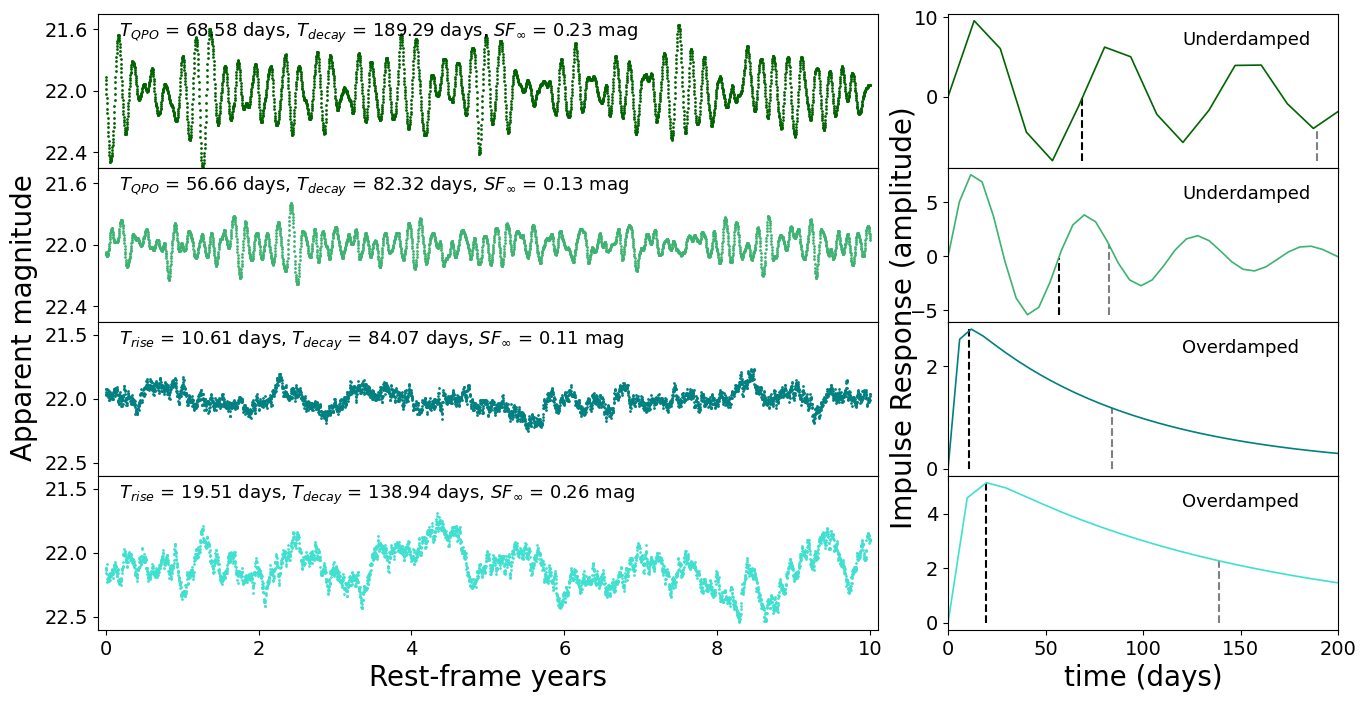

In [19]:
from scipy import signal
import matplotlib.ticker as mtick

# select 4 plots
alpha1_l = [0.0105658102065702, 0.0242953719051658,0.334851147762757,0.17619048029302]
alpha2_l = [0.00839484005558926,0.0122951437054628,0.00384145704148491,0.00121630251170779]
beta0_l = [0.0022,0.0022,0.003672,0.003672 ]
beta1_l = [0.00025, 0.00025, 0.0257, 0.0257]
T_qpo_rise_l = [68.5762377949766, 56.6647613192756, 10.6134146613897 , 19.5069691175971]
tau_l = [189.289790456042, 82.3202051735108,84.0713526467603, 138.940049756644]
sf_l = [0.23360848, 0.12730005,0.11160113, 0.2582008]

plt.rcParams.update(plt.rcParamsDefault)


colorlist = ['darkgreen','mediumseagreen','teal','turquoise']

# default settings: one observation per night

redshift = 0 #assume we simulate the rest-frame light curve
time_dilation = redshift + 1
np.random.seed()

nLC = 1
SNR = 1000
duration = 365*10
npts = 365*10


fig, axs = plt.subplots(4, 2, figsize=(16,8),sharex='col',gridspec_kw={'hspace': 0, 'wspace': 0.12, 'width_ratios': [2, 1]})


for row in np.arange(4):
    for col in np.arange(2):
        ar = [alpha1_l[row], alpha2_l[row]]
        ma = [beta0_l[row], beta1_l[row]]
        T_qpo_rise = T_qpo_rise_l[row]
        tau = tau_l[row]
        sf = sf_l[row]
        
        if col == 0:
            ax = axs[row,col]
            # simulate light curve
            dho_kernel = DHO_term(np.log(ar[0]), np.log(ar[1]), np.log(ma[0]), np.log(ma[1]))
            t_dho, y_dho, yerr_dho = gpSimFull(dho_kernel, SNR, duration, npts, nLC=nLC, log_flux=True)

            # add mean mag and mag errors for lsst
            y_dho = y_dho-yerr_dho
            y_dho += 22.0
            yerr_dho = np.zeros(len(y_dho))
#             y_dho, yerr_dho = add_lsst_noise(y_dho)
#             ax.errorbar(t_dho/365, y_dho, yerr_dho, fmt='.', markersize='1', c = colorlist[row], capsize=0.5, elinewidth=0.5 )
            ax.scatter(t_dho/365, y_dho, s = 1, c = colorlist[row])
#             ax.set_ylabel('mag', fontsize = 20)
            ax.set_xlabel('Rest-frame years', fontsize = 20)
            ax.invert_yaxis()
            if row == 0 or row == 1:
                ax.set_ylim([22.5,21.5])
                ax.set_yticks([22.4, 22.0, 21.6])
                ax.text(0.02,0.85,transform=ax.transAxes,s = r' $T_{QPO}$ = '+str(round(T_qpo_rise,2))+' days, $T_{decay}$ = '+str(round(tau,2))+' days, $SF_{\infty}$ = '+str(round(sf,2))+' mag', 
                fontsize = 13)
            else:
                ax.set_ylim([22.6,21.4])
                ax.set_yticks([22.5,22,21.5])
                ax.text(0.02,0.85,transform=ax.transAxes,s = r' $T_{rise}$ = '+str(round(T_qpo_rise,2))+' days, $T_{decay}$ = '+str(round(tau,2))+' days, $SF_{\infty}$ = '+str(round(sf,2))+' mag', 
                fontsize = 13)
            ax.set_xlim([-0.1,10.1])
            ax.tick_params(axis="x", labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
        if col == 1:
            ax = axs[row,col]
            carma = ([1.0], [1]+ar)
            t, y = signal.impulse(carma)
            ax.plot(t, y, c = colorlist[row], linewidth = 1.2)
            ax.set_xlim(0,200)
            ax.set_xlabel('time (days)',fontsize = 20)  
            ax.tick_params(axis="x", labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
            
            if row == 0 or row == 1:
                ax.text(0.6, 0.8, transform=ax.transAxes, s = r'Underdamped', fontsize = 13)
                t_qpo, y_qpo = signal.impulse(carma, T = T_qpo_rise, N = 900)
                ax.vlines(T_qpo_rise, min(y), y_qpo, colors = "black", linestyles = "dashed")
                
            else:
                ax.text(0.6, 0.8, transform=ax.transAxes, s = r'Overdamped', fontsize = 13)
                t_rise, y_rise = signal.impulse(carma, T = T_qpo_rise, N = 900)
                ax.vlines(T_qpo_rise, min(y),y_rise, colors = "black", linestyles = "dashed")
            t_tau, y_tau = signal.impulse(carma, T = tau)
            ax.vlines(tau, min(y),y_tau, colors = "grey", linestyles = "dashed")
fig.text(0.07, 0.5, 'Apparent magnitude', va='center', rotation='vertical', fontsize = 20)   
fig.text(0.62, 0.5, 'Impulse Response (amplitude)', va='center', rotation='vertical', fontsize = 20) 
plt.show()

In [36]:
y = signal.impulse(carma, T = T_qpo_rise)
print(y)

(array(19.50696912), array(5.14229124))


### 4.2 Plot Structure Function

In [24]:
import cmath
import math
# underdamped
def underdamped_acvf(alpha_1, alpha_2,beta_0, beta_1, t):
    r1 = (-1*alpha_1+cmath.sqrt(alpha_1**2-4*alpha_2))/2
    r2 = (-1*alpha_1-cmath.sqrt(alpha_1**2-4*alpha_2))/2
    c0 = 1/(2*(r2-r1))
    c1 = (beta_1**2*r1**2 - beta_0**2)/(r1.real*2*(r1))
    c2 = (beta_0**2 - beta_1**2*r2**2)/(r2.real*2*(r2))
    return c0*(c1*cmath.exp(r1*t)+c2*cmath.exp(r2*t))

def overdamped_acvf(alpha_1, alpha_2,beta_0, beta_1, t):
    r1 = (-1*alpha_1+np.sqrt(alpha_1**2-4*alpha_2))/2
    r2 = (-1*alpha_1-np.sqrt(alpha_1**2-4*alpha_2))/2
    c0 = 1/(2*(r2-r1))
    c1 = (beta_1**2*r1**2 - beta_0**2)/(r1*(r1+r2))
    c2 = (beta_0**2 - beta_1**2*r2**2)/(r2*(r2+r1))
    return c0*(c1*math.exp(r1*t)+c2*math.exp(r2*t))

def dho_sf(ma, ar, t):
    alpha_1 = ar[0]
    alpha_2 = ar[1]
    beta_0 = ma[0]
    beta_1 = ma[1]
    if alpha_1**2 - 4*alpha_2<0:
        acvf0 = underdamped_acvf(alpha_1, alpha_2,beta_0, beta_1, 0)
#         print("debug!!")
        result = (cmath.sqrt(2*(acvf0-underdamped_acvf(alpha_1, alpha_2,beta_0, beta_1, t)))).real
    else:
        acvf0 = overdamped_acvf(alpha_1, alpha_2,beta_0, beta_1, 0)
        acvft = overdamped_acvf(alpha_1, alpha_2,beta_0, beta_1, t)
#         print('debug: ',acvf0,  acvft)
        result = np.sqrt((acvf0-acvft)*2)
            
    return result
        
def drw_sf(SF_inft, tau, t):
    return SF_inft*np.sqrt(1 - np.exp(-np.absolute(t)/tau))     

0.9594072358133174
0.9322335289439431
0.2454896339370249
0.39077462434569504
0.4818207761456755


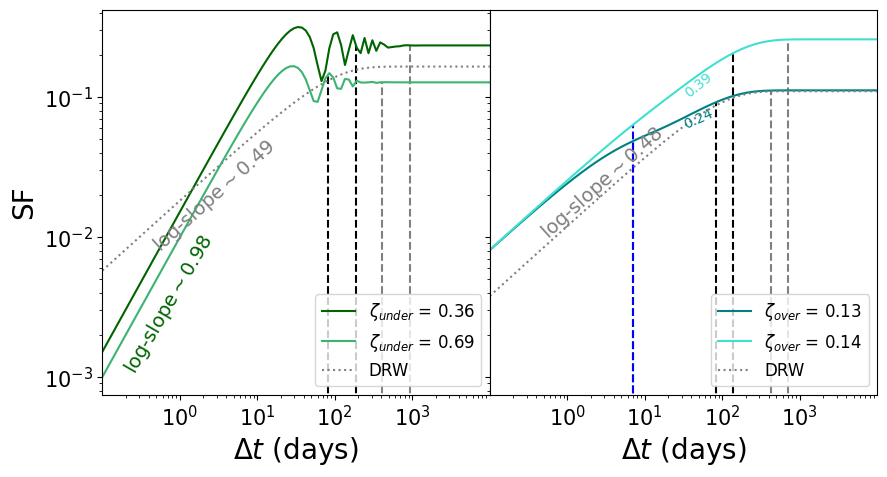

In [92]:


fig, axs = plt.subplots(1, 2, figsize=(10,5),sharey=True,gridspec_kw={'hspace': 0, 'wspace': 0, 'width_ratios': [1, 1]})

t_l = np.logspace(-1, 4, num = 100)

for i in np.arange(2): 
    ax = axs[0]
    ar = [alpha1_l[i], alpha2_l[i]]
    ma = [beta0_l[i], beta1_l[i]]
    sf_list = [dho_sf(ma, ar, t) for t in t_l]
    print(np.log10(sf_list[40]/sf_list[30])/np.log10(t_l[40]/t_l[30]))
    ax.vlines(tau_l[i], 0, dho_sf(ma, ar, tau_l[i]), colors = "black", linestyles = "dashed") 
    ax.vlines(tau_l[i]*5, 0, dho_sf(ma, ar, tau_l[i]*5), colors = "grey", linestyles = "dashed" )
    if i == 0:
#         ax.text(tau_l[i]+10, 1e-2, s = r'$T_{decay}$', fontsize = 14,rotation='vertical',)
#         ax.text(tau_l[i]*5+10, 1e-2, s = r'$5T_{decay}$', fontsize = 14,rotation='vertical',)
        ax.text(1.7e-1,1.1e-3, s = r'log-slope$\sim$0.98', fontsize = 14,rotation = 60,  color='darkgreen')
    zeta = T_qpo_rise_l[i]/tau_l[i]
    ax.plot(t_l, sf_list, c = colorlist[i],linewidth=1.5, 
                 label = r'$\zeta_{under}$ = '+str(round(zeta,2)))
ax.plot(t_l, drw_sf(0.165, 82, t_l), ':',c = 'grey', label = 'DRW')
ax.text(4e-1, 8e-3,s = r'log-slope$\sim$0.49', fontsize = 14,rotation = 42,  color='grey' )
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta t$ (days)', fontsize = 20)
ax.set_ylabel('SF', fontsize = 20)
ax.set_xlim(1e-1, 1e4)
ax.set_xticks([1e0,1e1,1e2,1e3])
ax.legend(loc = 'lower right', fontsize = 12)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)


for i in [2,3]:
    ax = axs[1]
    ar = [alpha1_l[i], alpha2_l[i]]
    ma = [beta0_l[i], beta1_l[i]]
    sf_list = [dho_sf(ma, ar, t) for t in t_l]
    zeta = T_qpo_rise_l[i]/tau_l[i]
    print(np.log10(sf_list[66]/sf_list[30])/np.log10(t_l[66]/t_l[30]))
    ax.plot(t_l, sf_list, c = colorlist[i],linewidth=1.5, 
                 label = r'$\zeta_{over}$ = '+str(round(zeta,2)))
    
    ax.vlines(tau_l[i], 0, dho_sf(ma, ar, tau_l[i]), colors = "black", linestyles = "dashed") 
    ax.vlines(tau_l[i]*5, 0, dho_sf(ma, ar, tau_l[i]*5), colors = "grey", linestyles = "dashed" ) 
    ax.vlines(beta1_l[i]/beta0_l[i], 0, dho_sf(ma, ar, beta1_l[i]/beta0_l[i]), colors = "blue", linestyles = "dashed"  )

ax.plot(t_l, drw_sf(0.11, 84, t_l), ':',c = 'grey', label = 'DRW')
print(np.log10(drw_sf(0.11, 84, t_l[40])/drw_sf(0.11, 84, t_l[30]))/np.log10(t_l[40]/t_l[30]))
ax.text(4e-1, 10e-3,s = r'log-slope$\sim$0.48', fontsize = 14,rotation = 42,  color='grey' )



ax.text(30, 6e-2, s = '0.24', color = colorlist[2],fontsize = 10, rotation = 24)
ax.text(30, 1e-1, s = '0.39', color = colorlist[3],fontsize = 10, rotation = 39)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta t$ (days)', fontsize = 20)
ax.set_xlim(1e-1, 1e4)
ax.set_xticks([1e0,1e1,1e2,1e3])
ax.legend(loc = 'lower right',fontsize = 12)
ax.tick_params(axis="x", labelsize=15)

plt.show()





In [89]:
t_l

array([1.00000000e-01, 1.12332403e-01, 1.26185688e-01, 1.41747416e-01,
       1.59228279e-01, 1.78864953e-01, 2.00923300e-01, 2.25701972e-01,
       2.53536449e-01, 2.84803587e-01, 3.19926714e-01, 3.59381366e-01,
       4.03701726e-01, 4.53487851e-01, 5.09413801e-01, 5.72236766e-01,
       6.42807312e-01, 7.22080902e-01, 8.11130831e-01, 9.11162756e-01,
       1.02353102e+00, 1.14975700e+00, 1.29154967e+00, 1.45082878e+00,
       1.62975083e+00, 1.83073828e+00, 2.05651231e+00, 2.31012970e+00,
       2.59502421e+00, 2.91505306e+00, 3.27454916e+00, 3.67837977e+00,
       4.13201240e+00, 4.64158883e+00, 5.21400829e+00, 5.85702082e+00,
       6.57933225e+00, 7.39072203e+00, 8.30217568e+00, 9.32603347e+00,
       1.04761575e+01, 1.17681195e+01, 1.32194115e+01, 1.48496826e+01,
       1.66810054e+01, 1.87381742e+01, 2.10490414e+01, 2.36448941e+01,
       2.65608778e+01, 2.98364724e+01, 3.35160265e+01, 3.76493581e+01,
       4.22924287e+01, 4.75081016e+01, 5.33669923e+01, 5.99484250e+01,
      

In [263]:
i = 3
ar = [alpha1_l[i], alpha2_l[i]]
ma = [beta0_l[i], beta1_l[i]]
dho_kernel = DHO_term(np.log(ar[0]), np.log(ar[1]), np.log(ma[0]), np.log(ma[1]))
t_dho, y_dho, yerr_dho = gpSimFull(dho_kernel, SNR, duration, npts, nLC=nLC, log_flux=True)
obs_SF_list, delta_list = calculate_SF(t_dho, y_dho)
plot_obs_SF(obs_SF_list, delta_list, 'u', np.std(y_dho)*np.sqrt(2))


t_l = np.logspace(-1, 4, num = 1000)
sf_l = [dho_sf(ma, ar, t) for t in t_l]
plt.plot(np.log10(t_l), sf_l, label = str(i))
plt.hlines(sf_l[i], t[0], t[-1], label = 'SF'+str(i))
plt.xscale('log')
plt.yscale('log')


NameError: name 'calculate_SF' is not defined

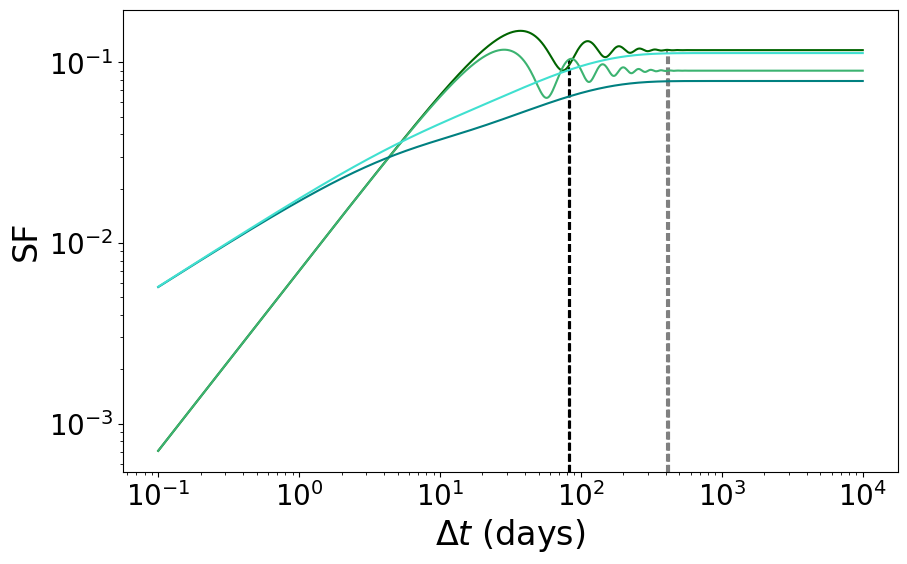

In [264]:

plt.figure(figsize = (10,6))


for i in np.arange(4):
    ar = np.array([alpha1_l[i], alpha2_l[i]])
    ma = np.array([beta0_l[i], beta1_l[i]])
    dho_sf = carma_sf(ar, ma)
    t = np.logspace(-1, 4, 1000)
    plt.plot(t, dho_sf(t), c = colorlist[i],linewidth=1.5)
    plt.vlines(tau_l[i], 0, dho_sf(tau_l[i]), colors = "black", linestyles = "dashed")
    plt.vlines(tau_l[i]*5, 0, dho_sf(tau_l[i]*10), colors = "grey", linestyles = "dashed" )

        

plt.xlabel(r'$\Delta t$ (days)', fontsize = 20)
plt.ylabel('SF', fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 15)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
plt.show()



<Figure size 1000x500 with 0 Axes>

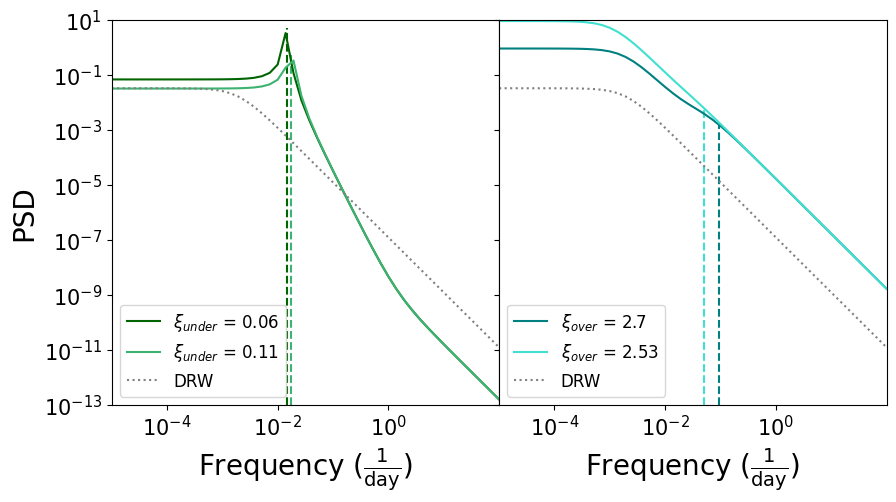

In [101]:
plt.figure(figsize = (10,5))

fig, axs = plt.subplots(1, 2, figsize=(10,5),sharey=True,gridspec_kw={'hspace': 0, 'wspace': 0, 'width_ratios': [1, 1]})

freq = np.logspace(-5, 2)
for i in np.arange(4):
    ar = np.array([alpha1_l[i], alpha2_l[i]])
    ma = np.array([beta0_l[i], beta1_l[i]])
    psd = carma_psd(ar, ma)
   
    psd1 = drw_psd(0.02/np.sqrt(2), 82)
    xi = alpha1_l[i]/(2*np.sqrt(alpha2_l[i]))
#     drw_psd = drw_psd(0.165, 82)
    if i in [0,1]:
        axs[0].plot(freq, psd(freq),c = colorlist[i],linewidth=1.5,label = r'$\xi_{under}$ = '+ str(round(xi,2)))
        axs[0].vlines(1/T_qpo_rise_l[i], 1e-13, psd(1/T_qpo_rise_l [i]),colors = colorlist[i], linestyles = "dashed")
        
    else:
        axs[1].plot(freq, psd(freq),c = colorlist[i],linewidth=1.5,label = r'$\xi_{over}$ = '+ str(round(xi,2)))
        axs[1].vlines(1/T_qpo_rise_l[i], 1e-13, psd(1/T_qpo_rise_l [i]),colors = colorlist[i], linestyles = "dashed")
        
axs[0].set_ylabel('PSD', fontsize = 20)
axs[0].plot(freq, psd1(freq), ':', c = 'grey', label = 'DRW' )
axs[1].plot(freq, psd1(freq), ':', c = 'grey', label = 'DRW' )
for ax in axs.flat:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1e-5,1e2])
    ax.set_ylim([1e-13,1e1])
    ax.set_xticks([1e-4,1e-2,1e0])
    ax.set_xlabel(r'Frequency ($\frac{1}{\mathrm{day}}$)', fontsize = 20)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.legend(loc = 'lower left',fontsize = 12)

plt.show()

In [28]:

from sympy import *


alpha_1= Symbol('alpha_1')
alpha_2= Symbol('alpha_2')
var = 1
tau = 100
beta_0, beta_1 = 0.003672,0.0257
solved_value = solve([tau*alpha_1 - tau**2*alpha_2 -1, 
                       (beta_0**2+beta_1**2*alpha_2)/(2*alpha_1*alpha_2)-var],
                     [alpha_1, alpha_2])
alpha_1 = solved_value[1][0]
alpha_2 = solved_value[1][1]

print(alpha_1, alpha_2)

0.0315763935871705 0.000215763935871705


In [4]:
df_under = pd.read_csv('model_params/DHO_under_params.csv',index_col=0)
df_over = pd.read_csv('model_params/DHO_over_params.csv',index_col=0)

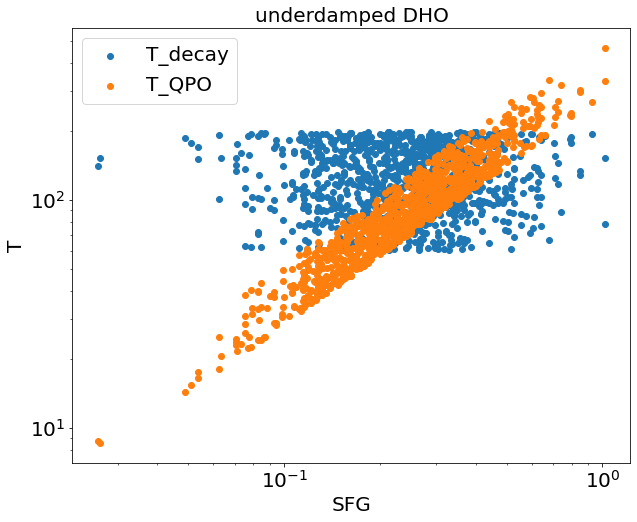

In [15]:
plt.figure(figsize = (10,8))
plt.scatter(df_under['SFG'], df_under['T_decay'], label = 'T_decay')
plt.scatter(df_under['SFG'], df_under['T_QPO'], label = 'T_QPO')
plt.legend(fontsize = 20)
plt.xlabel('SFG',fontsize = 20)
plt.ylabel('T',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.title('underdamped DHO',fontsize = 20)
plt.show()

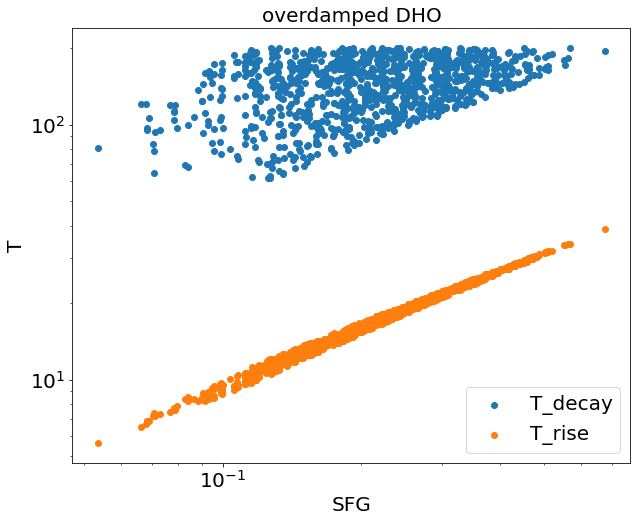

In [17]:
plt.figure(figsize = (10,8))
plt.scatter(df_over['SFG'], df_over['T_decay'], label = 'T_decay')
plt.scatter(df_over['SFG'], df_over['T_rise'], label = 'T_rise')
plt.legend(fontsize = 20)
plt.xlabel('SFG',fontsize = 20)
plt.ylabel('T',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.title('overdamped DHO',fontsize = 20)
plt.show()